In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf

from tensorflow import keras

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
print(pd.__version__)
plt.rcParams["figure.figsize"] = (20,16)

1.4.1


# Helper function

In [143]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='767541', max_subplots=3, max_timestamps=48):
        inputs, labels = self.example
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        max_l = min(max_timestamps, inputs.shape[1])
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices[-max_l:], inputs[n, -max_l:, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
            
            # forecasting dots
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])



# loading the dataset

In [5]:
metr_df = pd.read_csv("./data/metr-la.csv", index_col=0)
road_distances_df = pd.read_csv("./data/sensor_graph/distances_la_2021.csv", names=["from","to","cost"])
graph_sensor = pd.read_csv("./data/sensor_graph/graph_sensor_ids.txt", header=None, sep=",")

In [104]:
# The number of timestamps that need to be taken into account before predicting the next
T = [12, 24, 72, 144, 288] 

# Forecasting horizons of 5 minutes, 15 minutes, 30 minutes and 1 hour
H = [1, 3, 6, 12]

CONV_WIDTH = 12
LABEL_WIDTH = 6
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

NUM_FEATURES = metr_df.shape[1]
OUT_STEPS = 24

In [94]:
metr_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
773869,34272.0,54.631359,22.619199,0.0,60.364583,64.888889,66.875000,70.0
767541,34272.0,60.452789,15.970239,0.0,63.000000,65.000000,66.375000,70.0
767542,34272.0,60.726120,18.313353,0.0,65.444444,67.375000,68.444444,70.0
717447,34272.0,49.524287,15.843261,0.0,50.333333,53.875000,58.125000,70.0
717446,34272.0,46.079798,19.350345,0.0,34.666667,46.000000,64.500000,70.0
...,...,...,...,...,...,...,...,...
717592,34272.0,56.915083,18.260438,0.0,60.222222,63.000000,64.750000,70.0
717595,34272.0,62.484679,16.959238,0.0,65.888889,67.625000,68.625000,70.0
772168,34272.0,54.697381,16.303651,0.0,50.125000,61.125000,64.444444,70.0
718141,34272.0,58.920210,19.080474,0.0,62.888889,66.125000,67.750000,70.0


In [7]:
column_indices = {name: i for i, name in enumerate(metr_df.columns)}

n = len(metr_df)
train_metr_df = metr_df[:int(n * .7)]
val_metr_df = metr_df[int(n * .7):int(n * .9)]
test_metr_df = metr_df[int(n * .9):]

train_metr_mean = train_metr_df.mean()
train_metr_std = train_metr_df.std()

train_metr_df = (train_metr_df - train_metr_mean) / train_metr_std
val_metr_df = (val_metr_df - train_metr_mean) / train_metr_std
test_metr_df = (test_metr_df - train_metr_mean) / train_metr_std

In [144]:
single_step_window = WindowGenerator(
    input_width=1, 
    label_width=1, 
    shift=1,
    label_columns=['767541'], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

wide_window = WindowGenerator(
    input_width=288, 
    label_width=288, 
    shift=1,
    label_columns=['767541'], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['767541'],
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['767541'],
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

single_step_window_multi_output = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, 
    label_width=1, 
    shift=1,
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

wide_window_multi_output = WindowGenerator(
    input_width=288, 
    label_width=288, 
    shift=1,
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

multi_window = WindowGenerator(input_width=288,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)




In [139]:
multi_window

Total window size: 312
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 

In [138]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 207)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 288, 207)
Labels shape (batch, time, features): (32, 288, 1)


# Data analysis


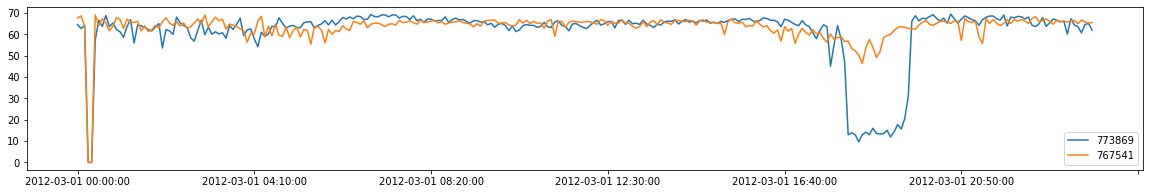

In [9]:
random_metr_data = metr_df[['773869', '767541']][:288]
random_metr_data.plot()
plt.show()

Inputs shape (batch, time, features): (32, 48, 207)
Labels shape (batch, time, features): (32, 1, 1)


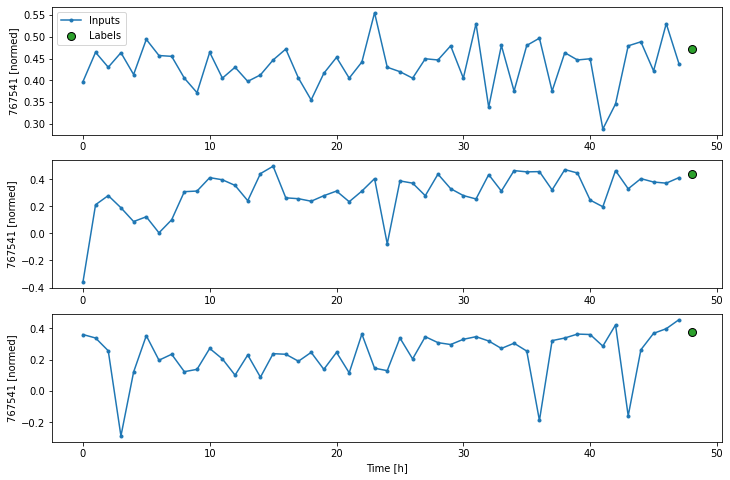

In [10]:
w2 = WindowGenerator(input_width=48, label_width=1, shift=1, label_columns=["767541"], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)
w2

example_window = tf.stack([np.array(train_metr_df[:w2.total_window_size]),
                           np.array(train_metr_df[100:100+w2.total_window_size]),
                           np.array(train_metr_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

w2.plot()

for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

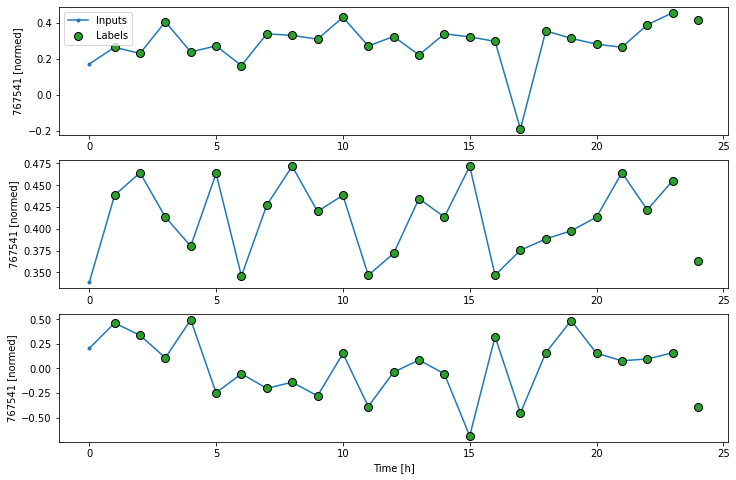

In [11]:
wide_window.plot()

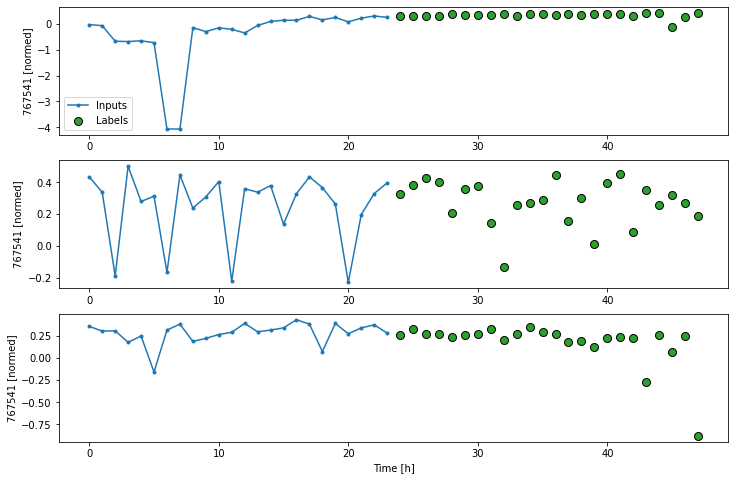

In [109]:
multi_window.plot()

In [12]:
G = nx.read_weighted_edgelist("./data/sensor_graph/distances_la_2021.csv", delimiter=",", nodetype=str)
G.number_of_nodes()

# nx.draw_kamada_kawai(G)

4106

# Models

In [67]:
MAX_EPOCHS = 20

class MyModel(tf.keras.Model):
    def __init__(self, num_features=1):
        super().__init__()
        self.num_features=num_features

    def compile_and_fit(self, model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
        return history

In [69]:
class Baseline(MyModel):
    def __init__(self, label_index=None, num_features=1):
        super().__init__(num_features=num_features)
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [71]:
class LinearModel(MyModel):
    def __init__(self, num_features=1):
        super().__init__(num_features=num_features)

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.num_features)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [72]:
class DenseModel(MyModel):
    def __init__(self, num_features=1):
        super().__init__(num_features=num_features)

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=self.num_features)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [73]:
class MultiDenseModel(MyModel):
    def __init__(self, num_features=1):
        super().__init__(num_features=num_features)

    def call(self, window):
        self.model = tf.keras.Sequential([
            # Shape: (time, features) => (time*features)
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=self.num_features),
            # Add back the time dimension.
            # Shape: (outputs) => (1, outputs)
            tf.keras.layers.Reshape([1, -1]),
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [55]:
class ConvModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [74]:
class LstmModel(MyModel):
    def __init__(self, num_features=1):
        super().__init__(num_features=num_features)

    def call(self, window):
        self.model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=self.num_features)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [115]:
class MultiStepLastBaseline(MyModel):
    def __init__(self, out_steps, num_features=1):
        super().__init__(num_features=num_features)
        self.out_steps = out_steps

    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, self.out_steps, 1])

In [161]:
class RepeatBaseline(MyModel):
    def __init__(self, out_steps, num_features=1):
        super().__init__(num_features=num_features)
        self.out_steps = out_steps

    def call(self, inputs):
        return inputs[:, -self.out_steps:, :]

In [165]:
class MultiLinearModel(MyModel):
    def __init__(self, out_steps, num_features=1):
        super().__init__(num_features=num_features)
        self.out_steps = out_steps
    
    def call(self, window):
        self.model = tf.keras.Sequential([
            # Take the last time-step.
            # Shape [batch, time, features] => [batch, 1, features]
            tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
            # Shape => [batch, 1, out_steps*features]
            tf.keras.layers.Dense(self.out_steps*self.num_features,
                                kernel_initializer=tf.initializers.zeros()),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.out_steps, self.num_features])
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

# Evaluation

## Single-output model

In [91]:
val_performance = {}
performance = {}

214/214 [==============================] - 1s 4ms/step - loss: 0.4905 - mean_absolute_error: 0.2307


ValueError: x and y must be the same size

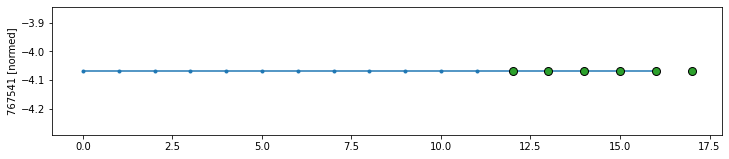

In [93]:
baseline = Baseline(label_index=column_indices['767541'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
wide_window.plot(baseline)

In [ ]:
linearModel = LinearModel()
val_performance['Linear'], performance["Linear"] = linearModel(single_step_window)
wide_window.plot(linearModel.model)

Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1667 - mean_absolute_error: 0.1992 - val_loss: 0.1645 - val_mean_absolute_error: 0.1995
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1408 - mean_absolute_error: 0.1657 - val_loss: 0.1476 - val_mean_absolute_error: 0.1812
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1327 - mean_absolute_error: 0.1595 - val_loss: 0.1435 - val_mean_absolute_error: 0.1822
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1286 - mean_absolute_error: 0.1541 - val_loss: 0.1386 - val_mean_absolute_error: 0.1522
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1246 - mean_absolute_error: 0.1492 - val_loss: 0.1391 - val_mean_absolute_error: 0.1663
Epoch 6/20
215/215 [==============================] - 1s 2ms/step - loss: 0.1459 - mean_absolute_error: 0.1635


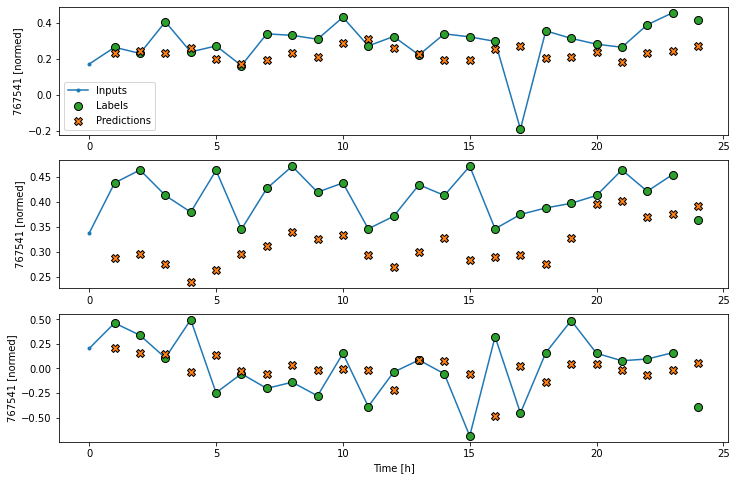

In [24]:
denseModel = DenseModel()
val_performance['Dense'], performance["Dense"] = denseModel(single_step_window)
wide_window.plot(denseModel.model)

Epoch 1/20
749/749 [==============================] - 3s 4ms/step - loss: 0.4958 - mean_absolute_error: 0.3541 - val_loss: 0.2724 - val_mean_absolute_error: 0.2610
Epoch 2/20
749/749 [==============================] - 3s 3ms/step - loss: 0.2270 - mean_absolute_error: 0.2675 - val_loss: 0.2675 - val_mean_absolute_error: 0.2937
Epoch 3/20
749/749 [==============================] - 3s 3ms/step - loss: 0.2183 - mean_absolute_error: 0.2530 - val_loss: 0.2376 - val_mean_absolute_error: 0.2431
Epoch 4/20
749/749 [==============================] - 3s 3ms/step - loss: 0.1796 - mean_absolute_error: 0.2273 - val_loss: 0.2309 - val_mean_absolute_error: 0.2462
Epoch 5/20
749/749 [==============================] - 3s 3ms/step - loss: 0.2286 - mean_absolute_error: 0.2602 - val_loss: 0.2056 - val_mean_absolute_error: 0.2192
Epoch 6/20
749/749 [==============================] - 3s 3ms/step - loss: 0.1682 - mean_absolute_error: 0.2131 - val_loss: 0.1787 - val_mean_absolute_error: 0.2023
Epoch 7/20
749/7

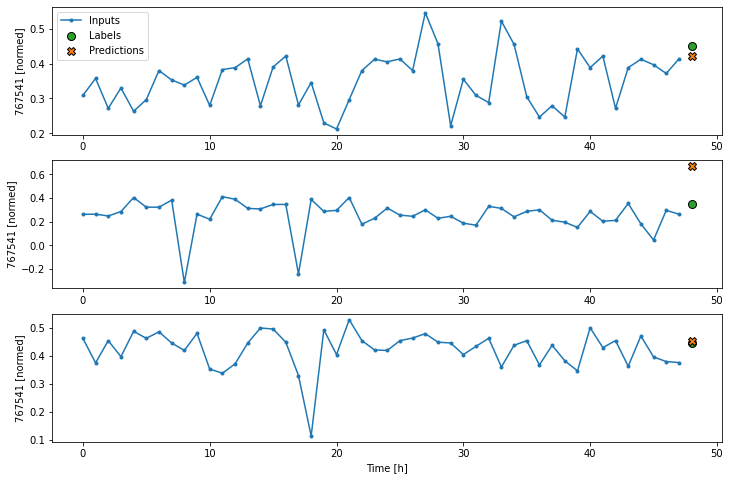

In [25]:
multiDenseModel = MultiDenseModel()
val_performance['MultiDense'], performance["MultiDense"] = multiDenseModel(conv_window)
conv_window.plot(multiDenseModel.model)

In [26]:
# convModel = ConvModel()
# val_performance['Conv'], performance["Conv"] = convModel(conv_window)
# conv_window.plot(convModel.model)
# wide_conv_window.plot(convModel)

Epoch 1/20
749/749 [==============================] - 7s 6ms/step - loss: 0.1300 - mean_absolute_error: 0.1632 - val_loss: 0.1475 - val_mean_absolute_error: 0.1827
Epoch 2/20
749/749 [==============================] - 4s 5ms/step - loss: 0.0966 - mean_absolute_error: 0.1340 - val_loss: 0.1644 - val_mean_absolute_error: 0.2075
Epoch 3/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1847 - mean_absolute_error: 0.2287


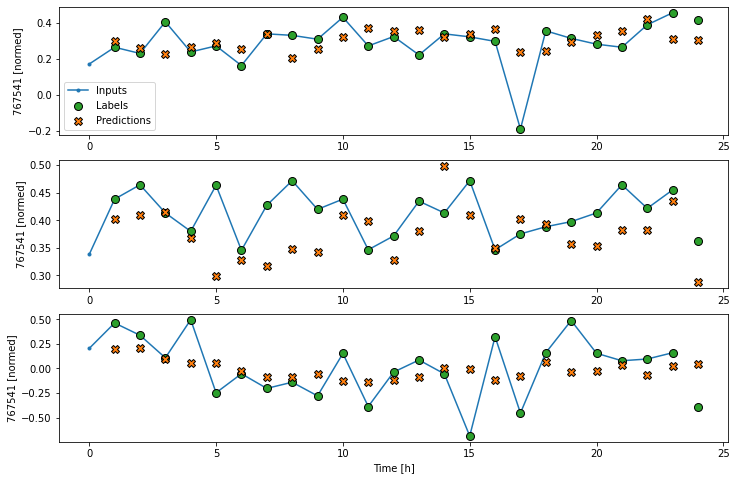

In [27]:
lstmModel = LstmModel()
val_performance['LSTM'], performance["LSTM"] = lstmModel(wide_window)
wide_window.plot(lstmModel.model)

{'Baseline': [0.14509963989257812, 0.14554834365844727], 'Linear': [0.17399831116199493, 0.186753511428833], 'Dense': [0.14590631425380707, 0.16350796818733215], 'MultiDense': [0.27073895931243896, 0.2517639696598053], 'LSTM': [0.18471691012382507, 0.22869403660297394]}
{'Baseline': [0.15246129035949707, 0.13795426487922668], 'Linear': [0.21916763484477997, 0.25117701292037964], 'Dense': [0.1591053009033203, 0.1715540736913681], 'MultiDense': [0.26617246866226196, 0.2615385055541992], 'LSTM': [0.2392062395811081, 0.27659881114959717]}


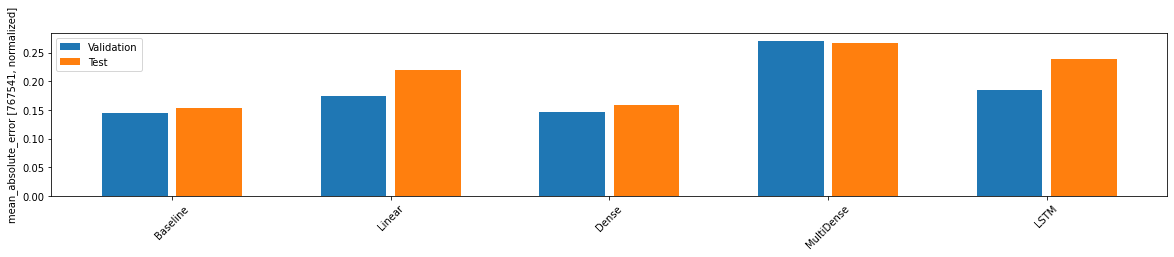

In [33]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
print(val_performance)
print(performance)
val_mae = [v[0] for v in val_performance.values()]
test_mae = [v[0] for v in performance.values()]

plt.ylabel('mean_absolute_error [767541, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Multi-output model

In [42]:
val_performance = {}
performance = {}

In [75]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Baseline'] = baseline.evaluate(single_step_window_multi_output.val)
performance['Baseline'] = baseline.evaluate(single_step_window_multi_output.test, verbose=0)

215/215 [==============================] - 1s 3ms/step - loss: 0.1366 - mean_absolute_error: 0.1630


Epoch 1/20
750/750 [==============================] - 4s 4ms/step - loss: 0.2979 - mean_absolute_error: 0.3231 - val_loss: 0.2667 - val_mean_absolute_error: 0.3021
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2006 - mean_absolute_error: 0.2598 - val_loss: 0.2340 - val_mean_absolute_error: 0.2835
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1828 - mean_absolute_error: 0.2450 - val_loss: 0.2208 - val_mean_absolute_error: 0.2756
Epoch 4/20
750/750 [==============================] - 3s 5ms/step - loss: 0.1735 - mean_absolute_error: 0.2367 - val_loss: 0.2242 - val_mean_absolute_error: 0.2850
Epoch 5/20
750/750 [==============================] - 3s 5ms/step - loss: 0.1670 - mean_absolute_error: 0.2311 - val_loss: 0.2203 - val_mean_absolute_error: 0.2800
Epoch 6/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1637 - mean_absolute_error: 0.2270 - val_loss: 0.2078 - val_mean_absolute_error: 0.2756
Epoch 7/20
750/7

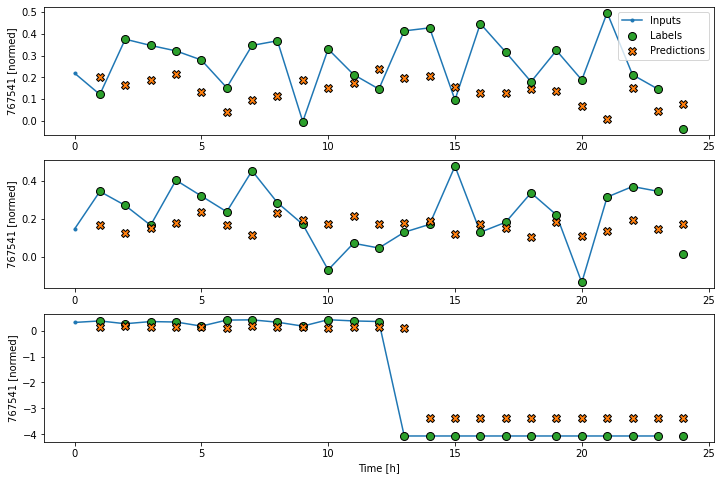

In [78]:
denseModel = DenseModel(NUM_FEATURES)
val_performance['Dense'], performance["Dense"] = denseModel(single_step_window_multi_output)
wide_window_multi_output.plot(denseModel.model)

In [ ]:
multiDenseModel = MultiDenseModel(NUM_FEATURES)
val_performance['MultiDense'], performance["MultiDense"] = multiDenseModel(wide_window_multi_output)
wide_window_multi_output.plot(multiDenseModel.model)

Epoch 1/20
749/749 [==============================] - 6s 6ms/step - loss: 0.3229 - mean_absolute_error: 0.3398 - val_loss: 0.2874 - val_mean_absolute_error: 0.3053
Epoch 2/20
749/749 [==============================] - 4s 6ms/step - loss: 0.1932 - mean_absolute_error: 0.2547 - val_loss: 0.2439 - val_mean_absolute_error: 0.2860
Epoch 3/20
749/749 [==============================] - 4s 6ms/step - loss: 0.1716 - mean_absolute_error: 0.2388 - val_loss: 0.2306 - val_mean_absolute_error: 0.2723
Epoch 4/20
749/749 [==============================] - 4s 6ms/step - loss: 0.1636 - mean_absolute_error: 0.2331 - val_loss: 0.2266 - val_mean_absolute_error: 0.2706
Epoch 5/20
749/749 [==============================] - 4s 6ms/step - loss: 0.1595 - mean_absolute_error: 0.2308 - val_loss: 0.2245 - val_mean_absolute_error: 0.2694
Epoch 6/20
749/749 [==============================] - 4s 6ms/step - loss: 0.1565 - mean_absolute_error: 0.2297 - val_loss: 0.2247 - val_mean_absolute_error: 0.2699
Epoch 7/20
214/2

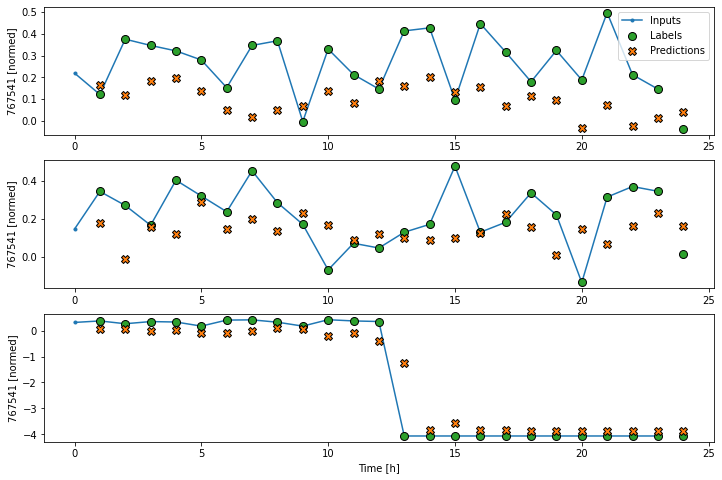

In [80]:
lstmModel = LstmModel(NUM_FEATURES)
val_performance['LSTM'], performance["LSTM"] = lstmModel(wide_window_multi_output)
wide_window_multi_output.plot(lstmModel.model)

{'Baseline': [0.13660173118114471, 0.16302917897701263], 'Dense': [0.19876758754253387, 0.260078102350235], 'LSTM': [0.22970901429653168, 0.280734121799469], 'MultiDense': [0.3506779670715332, 0.3352784812450409]}
{'Baseline': [0.13718877732753754, 0.15155231952667236], 'Dense': [0.322651207447052, 0.3537030518054962], 'LSTM': [0.34956732392311096, 0.34460482001304626], 'MultiDense': [0.45948877930641174, 0.37609246373176575]}


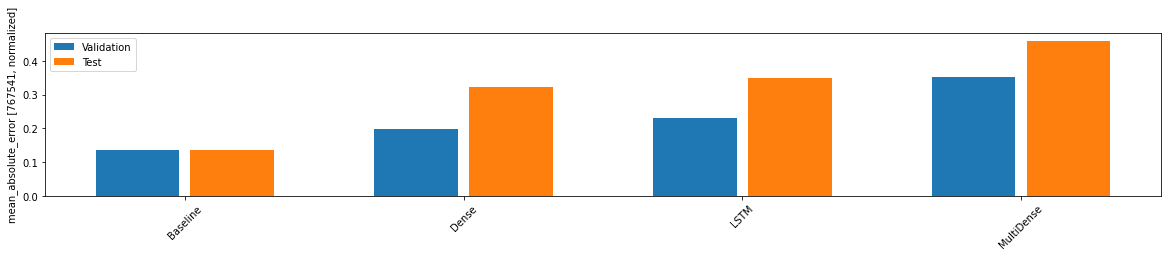

In [81]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
print(val_performance)
print(performance)
val_mae = [v[0] for v in val_performance.values()]
test_mae = [v[0] for v in performance.values()]

plt.ylabel('mean_absolute_error [767541, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Multi Step

In [113]:
multi_val_performance = {}
multi_performance = {}

205/205 [==============================] - 1s 5ms/step - loss: 0.7334 - mean_absolute_error: 0.3884


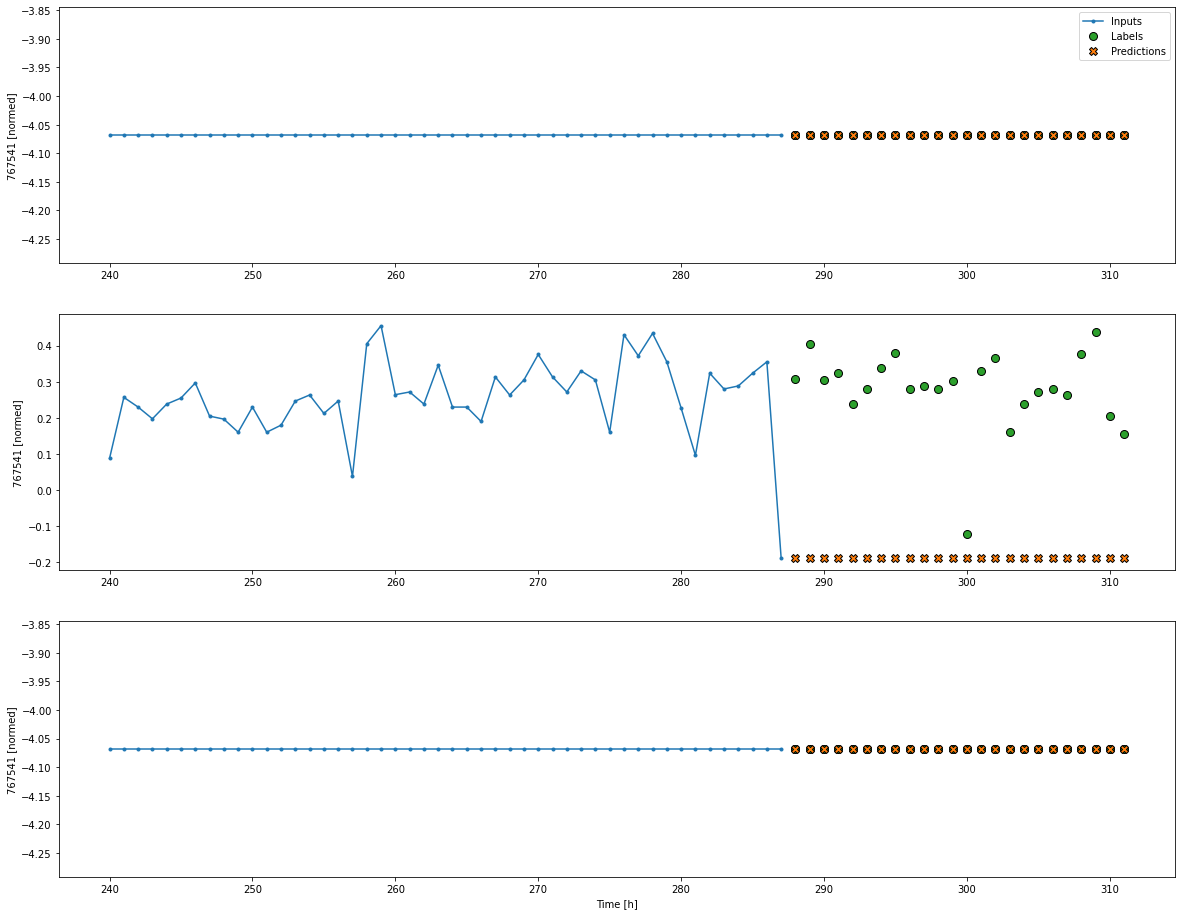

In [146]:
last_baseline = MultiStepLastBaseline(OUT_STEPS)
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

205/205 [==============================] - 1s 5ms/step - loss: 1.1552 - mean_absolute_error: 0.5461


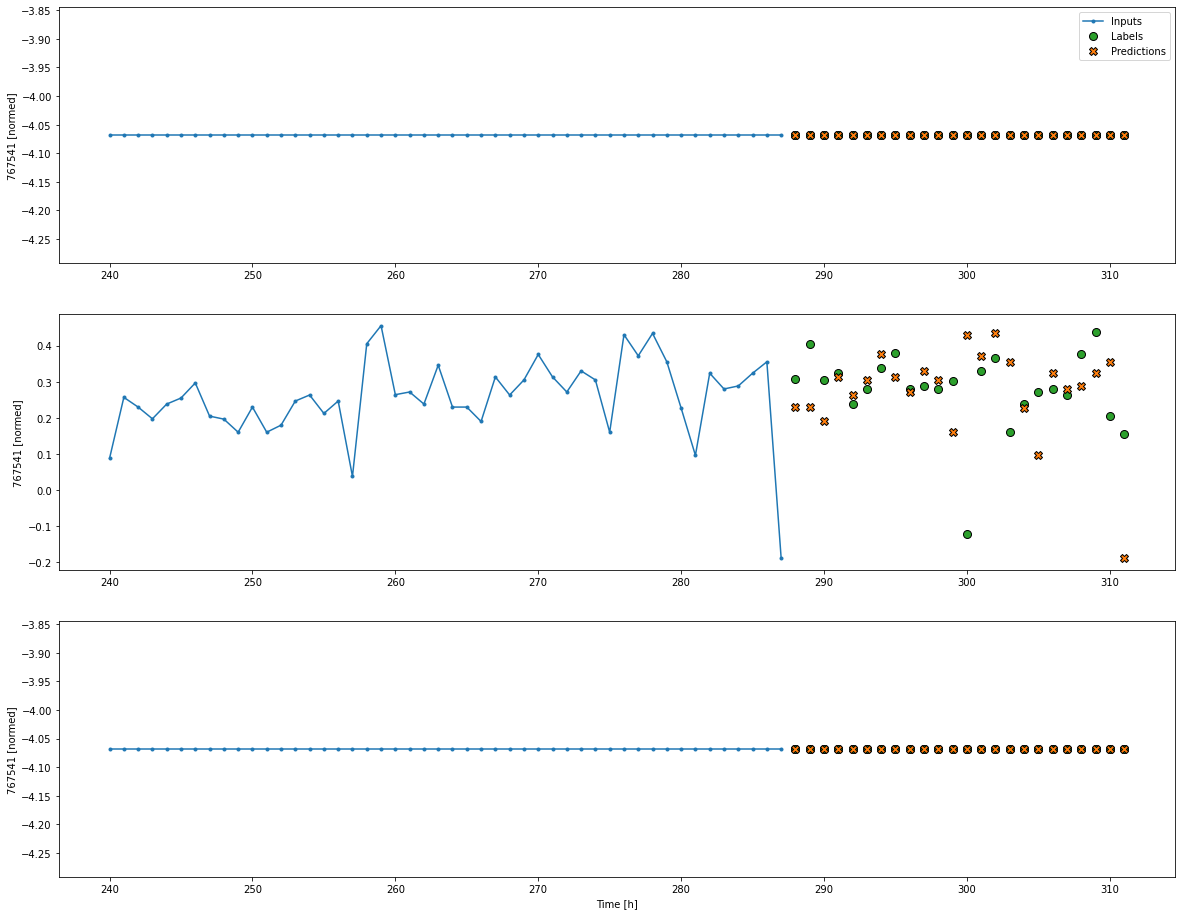

In [162]:
repeat_baseline = RepeatBaseline(OUT_STEPS)
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Epoch 1/20
740/740 [==============================] - 5s 6ms/step - loss: 0.4569 - mean_absolute_error: 0.3888 - val_loss: 0.5739 - val_mean_absolute_error: 0.4171
Epoch 2/20
740/740 [==============================] - 5s 6ms/step - loss: 0.4171 - mean_absolute_error: 0.3616 - val_loss: 0.5592 - val_mean_absolute_error: 0.4242
Epoch 3/20
740/740 [==============================] - 5s 7ms/step - loss: 0.4089 - mean_absolute_error: 0.3577 - val_loss: 0.5643 - val_mean_absolute_error: 0.4117
Epoch 4/20
740/740 [==============================] - 5s 7ms/step - loss: 0.4118 - mean_absolute_error: 0.3587 - val_loss: 0.5546 - val_mean_absolute_error: 0.4241
Epoch 5/20
740/740 [==============================] - 5s 7ms/step - loss: 0.4049 - mean_absolute_error: 0.3560 - val_loss: 0.5640 - val_mean_absolute_error: 0.4445
Epoch 6/20
205/205 [==============================] - 1s 4ms/step - loss: 0.5594 - mean_absolute_error: 0.4329


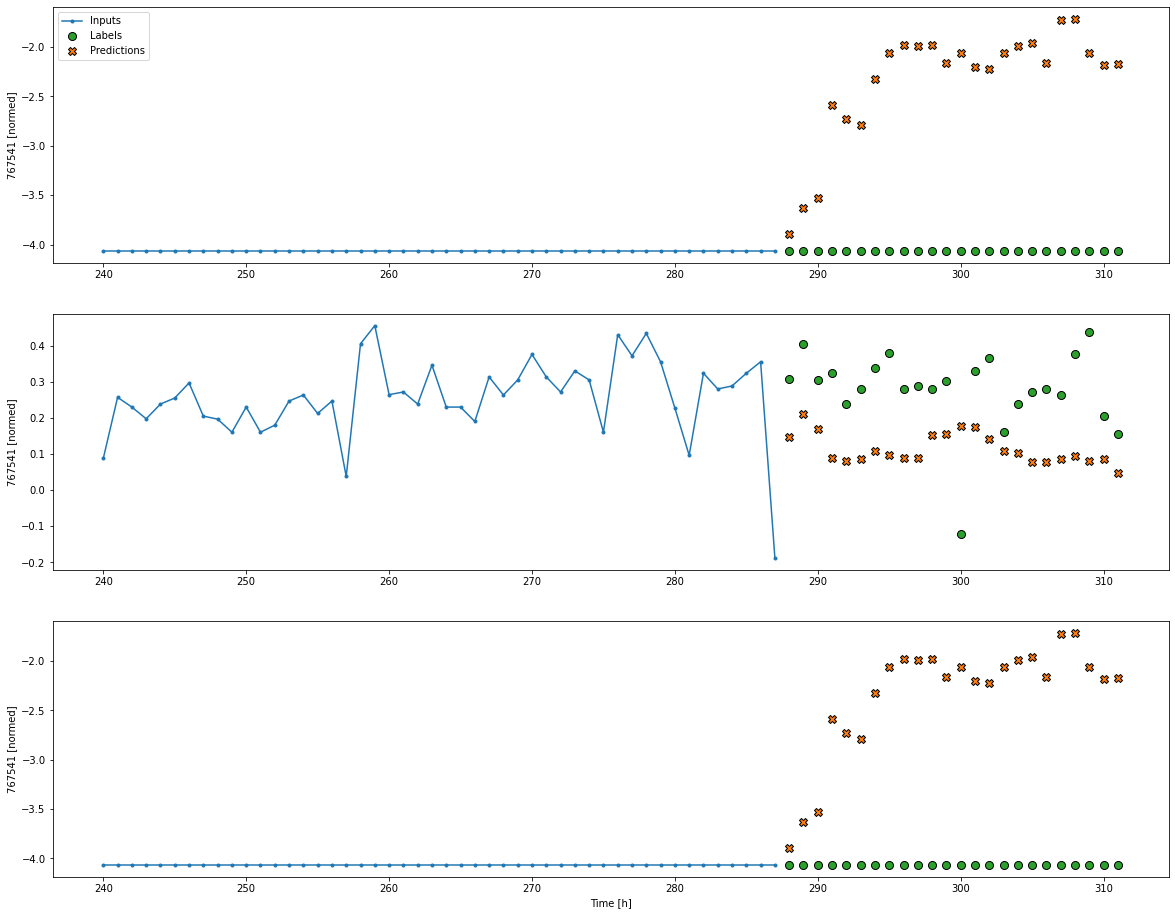

In [167]:
multiLinearModel = MultiLinearModel(out_steps=OUT_STEPS, num_features=NUM_FEATURES)
val_performance['MultiLinear'], performance["MultiLinear"] = multiLinearModel(multi_window)
multi_window.plot(multiLinearModel.model)

In [29]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [30]:
tf.test.is_built_with_cuda()
# tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']
